# 天池智慧交通预测挑战赛数据分析

## 1 数据集初探

通行时间表提供了132条路段的拓扑结构以及2016年3月到5月每条路段的通行时间和2016年6月6点到8点的通行时间；道路信息表提供了132条路段的长度、宽度及道路等级；路段表提供了这132条路段的上下游路段的信息。

### 1.1 导入通行时间表

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif']=['SimHei']
traveltime_df=pd.read_table('C:/data/tianchi/gy_link_travel_time_part1/gy_link_travel_time_part1.txt',sep=';')
df=traveltime_df.copy()

### 1.2 查看数据结构及各特征值属性

In [2]:
display(df.head(3))
df.info()

,link_ID,date,time_interval,travel_time
0,9377906285566510514,2016-05-21,"[2016-05-21 23:20:00,2016-05-21 23:22:00)",17.6
1,3377906288228510514,2016-05-21,"[2016-05-21 18:46:00,2016-05-21 18:48:00)",3.5
2,3377906284395510514,2016-05-21,"[2016-05-21 07:06:00,2016-05-21 07:08:00)",10.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7662384 entries, 0 to 7662383
Data columns (total 4 columns):
link_ID          uint64
date             object
time_interval    object
travel_time      float64
dtypes: float64(1), object(2), uint64(1)
memory usage: 233.8+ MB


我们可以看到该数据集只有四个特征，link_ID:为每条路段的唯一标识，为该数据集的主键；time_interval:为时间片特征，表示通行时间所属的时间片。

In [3]:
np.any(df.isnull()) == True  

False

提供的数据集无缺失值，但缺失了大量的时间片信息，我们需要将该部分缺失的时间片补齐

### 1.3 补充缺失时间片信息

In [4]:
df['start_time_interval']=pd.to_datetime(df['time_interval'].map(lambda x: x[1:20]))

df=df.drop(['date','time_interval'],axis=1)

我们需要构建一个包含完整的时间片信息的数据集

In [5]:
date_range = pd.date_range("2016-03-01 00:00:00", "2016-6-30 23:58:00", freq='2min')
new_index = pd.MultiIndex.from_product([df['link_ID'].unique(),date_range],names=['link_ID', 'start_time_interval'])
df1 = pd.DataFrame(index=new_index).reset_index()
df= pd.merge(df1, df, on=['link_ID', 'start_time_interval'], how='left')
df = df.loc[~((df['start_time_interval'].dt.month == 6) & 
                (df['start_time_interval'].dt.hour.isin([0,1,2,3,4,5,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])))]

构建新的时间特征

In [6]:
df['start_time_interval']=pd.to_datetime(df['start_time_interval'])
df['year']=df['start_time_interval'].dt.year
df['month']=df['start_time_interval'].dt.month
df['day']=df['start_time_interval'].dt.day
df['hour']=df['start_time_interval'].dt.hour
df['minute']=df['start_time_interval'].dt.minute

In [7]:
df.isnull().sum()

link_ID                      0
start_time_interval          0
travel_time            1318896
year                         0
month                        0
day                          0
hour                         0
minute                       0
dtype: int64

补充后的数据集travel_time存在大量缺失值，我们可以把是否存在缺失值当成一个特征，构建一个新的特征is_null,0为无缺失值，1为存在缺失值

In [8]:
def is_null(val):
    if pd.isnull(val):
        return 1
    else:
        return 0 

df['is_null'] = list(map(is_null, df['travel_time']))

我们再用每条路段每天的平均值来填补travel_time的缺失值

In [9]:
df['travel_time'] = df['travel_time'].fillna(df.groupby(['link_ID','month','day'])['travel_time'].transform('mean'))

In [10]:
df.isnull().sum()

link_ID                   0
start_time_interval       0
travel_time            1860
year                      0
month                     0
day                       0
hour                      0
minute                    0
is_null                   0
dtype: int64

我们发现填补完后仍存在少量缺失值，原因为某些路段存在缺失一整天时间片的情况，对于仍缺失部分，我们用每条路段每月的平均值进行填补

In [11]:
df['travel_time'] = df['travel_time'].fillna(df.groupby(['link_ID','month'])['travel_time'].transform('mean'))

In [12]:
df.isnull().sum()

link_ID                0
start_time_interval    0
travel_time            0
year                   0
month                  0
day                    0
hour                   0
minute                 0
is_null                0
dtype: int64

我们可以看到填补后的通行时间表已无缺失值

### 1.4 导入道路信息表及路段表

In [13]:
info_df=pd.read_table('C:/data/tianchi/gy_link_info.txt',sep=';')
top_df=pd.read_table('C:/data/tianchi/gy_link_top.txt',sep=';')

### 1.5 查看数据结构及各特征值属性

In [14]:
display(info_df.head(3))
display(top_df.head(3))

,link_ID,length,width,link_class
0,4377906289869500514,57,3,1
1,4377906284594800514,247,9,1
2,4377906289425800514,194,3,1


,link_ID,in_links,out_links
0,4377906289869500514,4377906285525800514,4377906281969500514
1,4377906284594800514,4377906284514600514,4377906285594800514
2,4377906289425800514,NaN,4377906284653600514


In [15]:
info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 4 columns):
link_ID       132 non-null uint64
length        132 non-null int64
width         132 non-null int64
link_class    132 non-null int64
dtypes: int64(3), uint64(1)
memory usage: 4.2 KB


In [16]:
top_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 3 columns):
link_ID      132 non-null uint64
in_links     126 non-null object
out_links    125 non-null object
dtypes: object(2), uint64(1)
memory usage: 3.2+ KB


数据集描述：道路信息表包含了132条道路的长度、宽度及道路等级；路段表包含了132条道路的上下游路段信息，其中in_links和out_links存在缺失值，缺失部分代表该路段无上游或下游路段

### 1.6 将道路上下游信息转化为上下游道路条数

In [17]:
top_df['in_links'] = top_df['in_links'].str.len().apply(lambda x: np.floor(x / 19))
top_df['out_links'] =top_df['out_links'].str.len().apply(lambda x: np.floor(x / 19))
top_df = top_df.fillna(0)
top_df['links_num'] = top_df['in_links'].astype('str') + ',' + top_df['out_links'].astype('str')

### 1.7 合并通行时间表和道路信息路段表

In [18]:
top_info_df=pd.merge(top_df,info_df,on='link_ID',how='left')
df=pd.merge(df,top_info_df,on='link_ID',how='left')

## 2 EDA

### 2.1 构建新的时间特征

道路通行时间很有可能受是否为工作日的影响，所以我们构造一个新的特征week:0-6分别表示周一至周日

In [19]:
df['week']=df['start_time_interval'].dt.dayofweek

因为道路通行时间很有可能受节假日的影响，所以我们构造一个新的特征holiday： 1：表示为节假日前一天； 2：表示为处于节假日中； 3：表示为节假日最后一天； 0：表示为工作日

In [21]:
df['date']=df['start_time_interval'].dt.date
holiday_df= pd.DataFrame([['2016-04-01',1],['2016-04-02',2],['2016-04-03',2],['2016-04-04',3],
                          ['2016-04-29',1],['2016-04-30',2],['2016-05-01',2],['2016-05-02',3],
                          ['2016-06-08',1],['2016-06-09',2],['2016-06-10',2],['2016-06-11',3]],
                         columns=['date', 'holiday'])
holiday_df['date']=pd.to_datetime(holiday_df['date'])
holiday_df['date']=holiday_df['date'].dt.date
df=pd.merge(df,holiday_df,on='date',how='left')
df=df.fillna(value=0)

### 2.2 周内通行时间分析

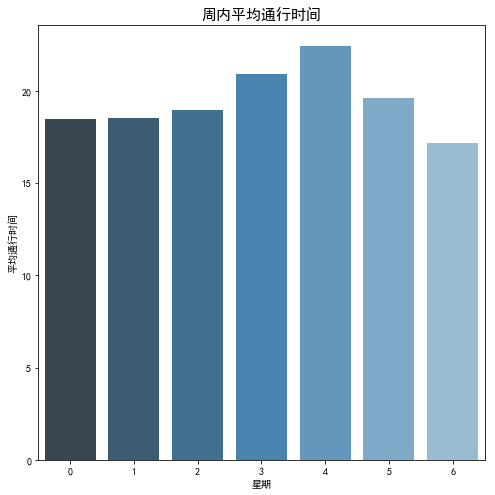

In [22]:
df_week_traveltime=df.groupby('week')['travel_time'].mean().sort_values(ascending=False).to_frame().reset_index()
f,ax1=plt.subplots(figsize=(8,8))
sns.barplot(x='week',y='travel_time',palette='Blues_d',data=df_week_traveltime,ax=ax1)
ax1.set_title('周内平均通行时间',fontsize=15)
ax1.set_xlabel('星期')
ax1.set_ylabel('平均通行时间')
plt.show()

从上图我们发现从总体来说周五各路段的平均通行时间最长

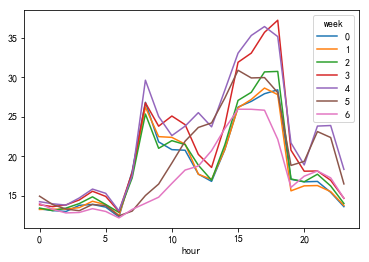

In [23]:
df.groupby(['hour','week'])['travel_time'].mean().unstack().plot()
plt.show()

从上图我们发现周六、周日平均通行时间趋势较一致，周一到周五平均通行时间变化趋势也较为一致，一般早高峰时间为早上8点到9点，晚高峰时间为下午5点到6点

### 2.3 节假日通行时间分析

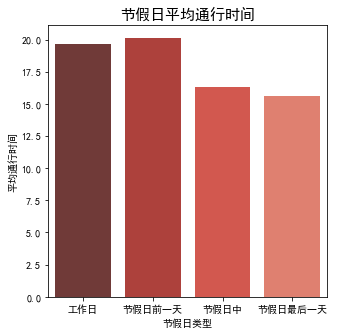

In [24]:
df_holiday_traveltime=df.groupby('holiday')['travel_time'].mean().to_frame().reset_index()
f,ax1=plt.subplots(figsize=(5,5))
sns.barplot(x='holiday',y='travel_time',palette='Reds_d',data=df_holiday_traveltime,ax=ax1)
ax1.set_title('节假日平均通行时间',fontsize=15)
ax1.set_xlabel('节假日类型')
ax1.set_ylabel('平均通行时间')
plt.xticks([0,1,2,3],['工作日', '节假日前一天', '节假日中', '节假日最后一天'])
plt.show()

从上图我们发现节假日前一天平均通行时间与工作日差别不大，而节假日中和节假日最后一天反而平均通行时间比工作日要短，可能与节假日人们的出行方式有关系

### 2.4 不同路段通行时间分析

In [25]:
traveltime_link_ID=df.groupby('link_ID')['travel_time'].agg([np.mean,np.median,np.std,np.min,np.max]).reset_index()
traveltime_link_ID=traveltime_link_ID.sort_values(by='std',ascending=False).reset_index()
traveltime_link_ID=pd.merge(traveltime_link_ID,top_info_df,on='link_ID',how='left')

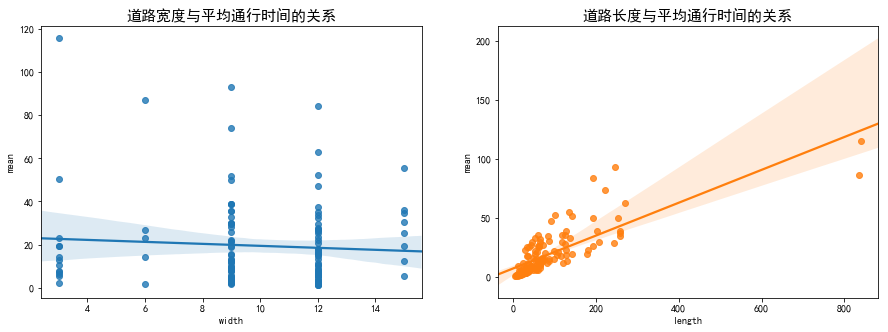

In [26]:
f,[ax1,ax2]=plt.subplots(1,2,figsize=(15,5))
sns.regplot(x='width',y='mean',data=traveltime_link_ID,ax=ax1)
ax1.set_title('道路宽度与平均通行时间的关系',fontsize=15)
sns.regplot(x='length',y='mean',data=traveltime_link_ID,ax=ax2)
ax2.set_title('道路长度与平均通行时间的关系',fontsize=15)
plt.show()

从上两幅图我们可以看到道路越长平均通行时间越长，而道路宽度越窄却没有表现出较明显的趋势

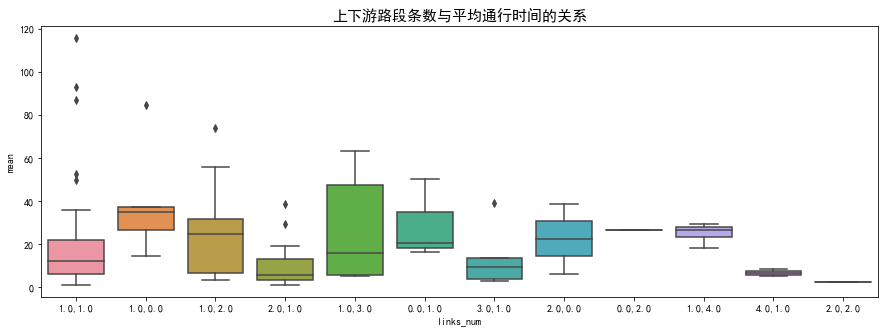

In [27]:
f,ax1=plt.subplots(figsize=(15,5))
sns.boxplot(x='links_num',y='mean',data=traveltime_link_ID,ax=ax1)
ax1.set_title('上下游路段条数与平均通行时间的关系',fontsize=15)
plt.show()

从上图可以看出不同道路的结构对于平均通行时间的分布还是有显著的影响的，其中[1.0,0.0]即上游仅有一条路段而无下游路段的道路平均通行时间最长

### 2.5 波动较大前五条路段分析

In [28]:
print(traveltime_link_ID.ix[:4,['link_ID']]) 

               link_ID
0  4377906284594800514
1  4377906280815800514
2  4377906280163800514
3  4377906283525800514
4  4377906284525800514


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [29]:
top5_df=df[(df['link_ID']==4377906284594800514)|(df['link_ID']==4377906280815800514)|(df['link_ID']==4377906280163800514)
          |(df['link_ID']==4377906283525800514)|(df['link_ID']==4377906284525800514)]

#### 2.5.1 周内通行时间分析

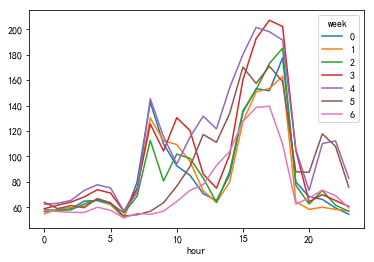

In [30]:
top5_df.groupby(['hour','week'])['travel_time'].mean().unstack().plot()
plt.show()

总体来看波动较大前五条路段周六日通行时间趋势较一致，而工作日中周四和周五的通行时间趋势较为一致 

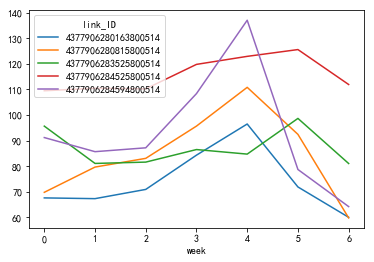

In [31]:
top5_df.groupby(['week','link_ID'])['travel_time'].mean().unstack().plot()
plt.show()

我们可以看到选取的五条路段平均通行时间在周五达到一个峰值

#### 2.5.2 每月通行时间分析

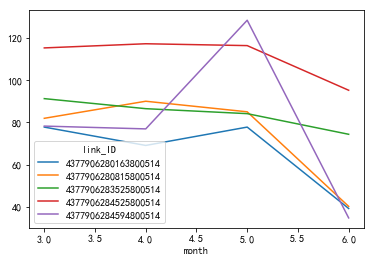

In [32]:
top5_df.groupby(['month','link_ID'])['travel_time'].mean().unstack().plot()
plt.show()

我们可以看到选取的五条路段平均通行时间在5月达到一个峰值

#### 2.5.3节假日通行时间分析

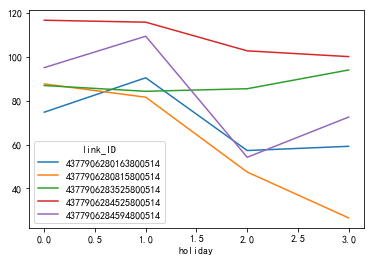

In [33]:
top5_df.groupby(['holiday','link_ID'])['travel_time'].mean().unstack().plot()
plt.show()

我们可以明显看到节假日前一天平均通行时间达到峰值，而在节假日中和节假日最后一天平均通行时间则明显低于工作日，这与人们节假日的出行方式有很大关系，增加节假日这一特征对我们预测通行时间的模型很有必要。

### 2.6 考虑增加不同路段不同统计时间的均值、方差等特征

In [34]:
traveltime_month=df.groupby(['link_ID','month'])['travel_time'].agg([np.mean,np.median,np.std,np.min,np.max]).reset_index()
df=pd.merge(df,traveltime_month,on=['link_ID','month'],how='left')
traveltime_month_day=df.groupby(['link_ID','month','day'])['travel_time'].agg([np.mean,np.median,np.std,np.min,np.max]).reset_index()
df=pd.merge(df,traveltime_month_day,on=['link_ID','month','day'],how='left')
traveltime_month_day_hour=df.groupby(['link_ID','month','day','hour'])['travel_time'].agg([np.mean,np.median,np.std,np.min,np.max]).reset_index()
df=pd.merge(df,traveltime_month_day_hour,on=['link_ID','month','day','hour'],how='left')
traveltime_month_hour=df.groupby(['link_ID','month','hour'])['travel_time'].agg([np.mean,np.median,np.std,np.min,np.max]).reset_index()
df=pd.merge(df,traveltime_month_hour,on=['link_ID','month','hour'],how='left')
traveltime_month_day=df.groupby(['link_ID','month','day'])['travel_time'].agg([np.mean,np.median,np.std,np.min,np.max]).reset_index()
df=pd.merge(df,traveltime_month_day,on=['link_ID','month','day'],how='left')
traveltime_day_hour=df.groupby(['link_ID','day','hour'])['travel_time'].agg([np.mean,np.median,np.std,np.min,np.max]).reset_index()
df=pd.merge(df,traveltime_day_hour,on=['link_ID','day','hour'],how='left')
traveltime_month_hour_minute=df.groupby(['link_ID','month','hour','minute'])['travel_time'].agg([np.mean,np.median,np.std,np.min,np.max]).reset_index()
df=pd.merge(df,traveltime_month_hour_minute,on=['link_ID','month','hour','minute'],how='left')
traveltime_day_hour_minute=df.groupby(['link_ID','day','hour','minute'])['travel_time'].agg([np.mean,np.median,np.std,np.min,np.max]).reset_index()
df=pd.merge(df,traveltime_day_hour_minute,on=['link_ID','day','hour','minute'],how='left')

### 2.7 删除不纳入模型的特征值

In [36]:
df=df.drop(['date','start_time_interval','links_num'],axis=1)

## 3 模型预测

### 3.1 构造训练集、测试集

In [37]:
model_df=df[df['link_ID']==4377906284594800514]
model_df=model_df.drop(['link_ID'],axis=1)
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(model_df, test_size=0.3 , random_state=100)
train_labels = train_set.pop('travel_time')
test_labels = test_set.pop('travel_time')

### 3.2训练随机森林模型

In [38]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 100, 
                            max_depth=11,
                           max_features = 0.8,
                           min_samples_split = 3)
rfr.fit(train_set,train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features=0.8, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### 3.3 模型性能评估（采用MAPE）

In [39]:
train_pred = rfr.predict(train_set)
mape_one_line_train = np.mean( abs( (train_pred - train_labels) / train_labels ) ) 
test_pred = rfr.predict(test_set)
mape_one_line_test  = np.mean( abs( (test_pred - test_labels) / test_labels ) ) 
print('其中某一条路段训练集的mape为:',mape_one_line_train)
print('其中某一条路段测试集的mape为:',mape_one_line_test)

其中某一条路段训练集的mape为: 0.15071037372866036
其中某一条路段测试集的mape为: 0.17227310281372918


### 3.4 可视化误差

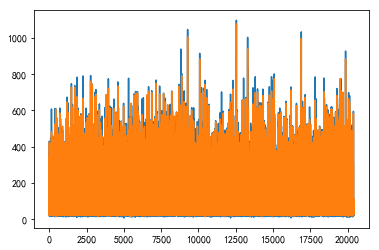

In [40]:
x_data = range(len(test_labels))
plt.plot(x_data,test_labels)
plt.plot(x_data,test_pred)
plt.show()

选取前50个样本进行可视化

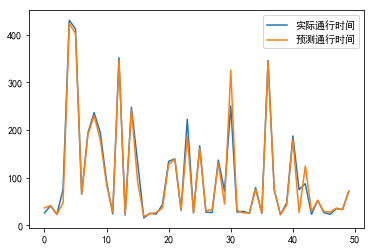

In [41]:
x_data = range(len(test_labels[0:50]))
plt.plot(x_data,test_labels[0:50])
plt.plot(x_data,test_pred[0:50])
plt.legend(['实际通行时间', '预测通行时间'])  
plt.show()